In [106]:
# imports and functions, does nothing

TMP_FILE = "fulldata-random.tmp.npy"

from functools import partial
from IPython.display import Image, display, Video, Image, HTML
from matplotlib import rcParams
from prettytable import PrettyTable
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.multiclass import unique_labels
import sys
sys.path.append('../..')
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import pathlib
import random
import sklearn
import random
import matplotlib
matplotlib.rcParams.update({'font.size': 14})


def img(path, width=400):
    rnd = random.randint(0,2e9)
    return f"""<img src="{path}?nocache={rnd}" style="width:{width}px; "></img>"""


In [107]:
data_all = np.load('quic-100p-338-40-loops-har.npy', allow_pickle=True).item()
data = data_all['both'] # adblock + decentraleyes
urls = [url for url in data]

In [108]:
import numpy as np
import math
import sys
import random

def average(array):
    if array is None or len(array) == 0:
        return 0
    return np.average(array)

def array_to_fix_size(array, length, pad_with=0):
    if len(array) < length:
        array.extend([pad_with] * (length - len(array)))
    elif len(array) > length:
        array = array[:length]
    return array

def split_in_chunks(array, num_splits):
    avg = len(array) / float(num_splits)
    out = []
    last = 0.0
    while last < len(array):
        out.append(array[int(last): int(last + avg)])
        last += avg
    return out

def get_packet_inter_times(data):
    if len(data) == 0:
        return [0]
    times = [x[0] for x in data]
    result = []
    for elem, next_elem in zip(times, times[1:] + [times[0]]):
        result.append(next_elem - elem)
    return result[:-1]

def add_intertimes_stats(features, data, incoming, outgoing):
    # statistics about the inter-packet durations

    def add_stats(trace, prefix=''):
        if trace is not None and len(trace) > 0:
            features['intertime_'+prefix+'max'] = max(trace)
            features['intertime_'+prefix + 'avg'] = average(trace)
            features['intertime_'+prefix+'std'] = np.std(trace)
            features['intertime_'+prefix+'p75'] = np.percentile(trace, 75)
        else:
            features['intertime_'+prefix+'p25'] = 0
            features['intertime_'+prefix+'p50'] = 0
            features['intertime_'+prefix+'p75'] = 0
            features['intertime_'+prefix+'p100'] = 0

    incoming_intertimes = get_packet_inter_times(incoming)
    outgoing_intertimes = get_packet_inter_times(outgoing)
    all_intertimes = get_packet_inter_times(data)

    add_stats(incoming_intertimes, 'incoming_')
    add_stats(outgoing_intertimes, 'outgoing_')
    add_stats(all_intertimes, '')


def add_time_percentiles(features, data, incoming, outgoing):
    # percentiles about the times in which packets where sent/received

    def add_percentiles(trace, prefix=''):
        if trace is not None and len(trace) > 0:
            features['time_'+prefix+'p25'] = np.percentile(trace, 25)
            features['time_'+prefix+'p50'] = np.percentile(trace, 50)
            features['time_'+prefix+'p75'] = np.percentile(trace, 75)
            features['time_'+prefix+'p100'] = np.percentile(trace, 100)
        else:
            features['time_'+prefix+'p25'] = 0
            features['time_'+prefix+'p50'] = 0
            features['time_'+prefix+'p75'] = 0
            features['time_'+prefix+'p100'] = 0

    incoming_times = [x[0] for x in incoming]
    outgoing_times = [x[0] for x in outgoing]
    times = [x[0] for x in data]

    add_percentiles(incoming_times, 'incoming_')
    add_percentiles(outgoing_times, 'outgoing_')
    add_percentiles(times, '')

    features['times_sum'] = sum(times)


def add_counts_in_out_last_first_30(features, data):
    # counts (incoming, outgoing) packets in the (first, last) 30 packets

    # NB: these features don't make much sense for HARs

    first30 = data[:30]
    last30 = data[-30:]
    first30in = []
    first30out = []
    for p in first30:
        if p[1] > 0: 
            first30in.append(p)
        if p[2] >= 0:
            first30out.append(p)
    last30in = []
    last30out = []
    for p in last30:
        if p[1] > 0:
            last30in.append(p)
        if p[2] >= 0:
            last30out.append(p)

    features['f30_n_incoming'] = len(first30in)
    features['f30_n_outgoing'] = len(first30out)
    features['l30_n_incoming'] = len(last30in)
    features['l30_n_outgoing'] = len(last30out)


def add_outgoing_concentrations_stats(features, data):
    # concentration of outgoing packets in chunks of 20 packets

    chunks = [data[x: x + 20] for x in range(0, len(data), 20)]
    concentrations = []
    for item in chunks:
        c = 0
        for p in item:
            if p[2] >= 0: # outgoing packets
                c += 1
        concentrations.append(c)

    concentrations = array_to_fix_size(concentrations, 40)

    features['outgoing_concentrations_std'] = np.std(concentrations)
    features['outgoing_concentrations_mean'] = average(concentrations)
    features['outgoing_concentrations_p50'] = np.percentile(concentrations, 50)
    features['outgoing_concentrations_min'] = min(concentrations)
    features['outgoing_concentrations_max'] = max(concentrations)

    i = 0
    while i < len(concentrations):
        features['outgoing_concentrations_'+str(i)] = concentrations[i]
        i += 1

    # Same think, but for trace divided in 70 fixed chunks

    outgoing_concentrations_70 = [
        sum(x) for x in split_in_chunks(concentrations, 70)]

    i = 0
    while i < len(outgoing_concentrations_70):
        features['outgoing_concentrations_70_' +
                 str(i)] = outgoing_concentrations_70[i]
        i += 1

    features['outgoing_concentrations_70_sum'] = sum(
        outgoing_concentrations_70)


def add_delta_rates_stats(features, data):
    # Average number packets sent and received per second

    last_time = data[-1][1]
    last_second = math.ceil(last_time)

    count_per_sec = []
    for sec in range(1, int(last_second) + 1):
        count = 0
        for p in data:
            if p[0] <= sec: # p[0] is packet time
                count += 1
        count_per_sec.append(count)

    count_per_sec = array_to_fix_size(count_per_sec, 10)

    delta_count_per_sec = [0]  # first difference is 0
    i = 1
    while i < len(count_per_sec):
        diff = count_per_sec[i] - count_per_sec[i-1]
        delta_count_per_sec.append(diff)
        i += 1

    features['delta_rate_avg'] = average(delta_count_per_sec)
    features['delta_rate_std'] = np.std(delta_count_per_sec)
    features['delta_rate_p50'] = np.percentile(delta_count_per_sec, 50)
    features['delta_rate_min'] = min(delta_count_per_sec)
    features['delta_rate_max'] = max(delta_count_per_sec)

    i = 1
    while i < len(delta_count_per_sec):
        features['delta_rate_'+str(i)] = delta_count_per_sec[i]
        i += 1

    # Same thing, but trace divided in 20 fixed chunks

    delta_counts_20 = [sum(x)
                       for x in split_in_chunks(delta_count_per_sec, 20)]

    i = 0
    while i < len(delta_counts_20):
        features['delta_rates_20_'+str(i)] = delta_counts_20[i]
        i += 1

    features['delta_rates_20_sum'] = sum(delta_counts_20)


def extract_features(data, max_size=123):
    features = dict()


    if len(data) == 0:
        return array_to_fix_size([], max_size, pad_with=('*', 0))

    def quic_to_1(s):
        if s=='quic':
            return 1
        return 0

    outgoing = [pkt for pkt in data if pkt[1] > 0]
    incoming = [pkt for pkt in data if pkt[2] > 0]

    features['n_incoming'] = len(incoming)
    features['n_outgoing'] = len(outgoing)
    features['n_total'] = len(data)
    features['%_in'] = len(incoming) / float(len(data))
    features['%_out'] = len(outgoing) / float(len(data))
    
    features['bytes_incoming'] = sum([d[2] for d in incoming])
    features['bytes_outgoing'] = sum([d[1] for d in outgoing])
    features['bytes_total'] = features['bytes_incoming'] + features['bytes_outgoing']
    if features['bytes_total'] > 0:
        features['bytes_%_in'] = features['bytes_incoming'] / float(features['bytes_total'])
        features['bytes_%_out'] = features['bytes_outgoing'] / float(features['bytes_total'])
    else:
        features['bytes_%_in'] = 0
        features['bytes_%_out'] = 0

    add_intertimes_stats(features, data, incoming, outgoing)
    add_time_percentiles(features, data, incoming, outgoing)
    add_counts_in_out_last_first_30(features, data)

    add_delta_rates_stats(features, data)

    # added size features; TLS max is -16K +16k
    incoming_sizes = [x[2] for x in incoming]
    bins = np.linspace(0, 16*1024, 50)
    hist, bin_edges = np.histogram(incoming_sizes, bins=bins, density=False)

    i = 0
    while i < len(hist):
        features['hist_'+str(round(bin_edges[i]))] = hist[i]
        i += 1

    # unmap feature dictionnary for padding
    tuples = [(k, v) for k, v in features.items()]

    features = array_to_fix_size(tuples, max_size, pad_with=('*', 0))

    return features

def trace_starts_at_time0(X):

    if len(X) == 0:
        return X

    t0 = X[0][0]
    i = 0
    while i<len(X):
        X[i][0] -= t0
        i += 1

    return X

def get_features(hars):
    result = dict(feature_names=None, feature=[], label=[])

    result = dict()
    result['feature_names'] = None
    result['features'] = [] #X
    result['labels'] = [] #y

    for i, url in enumerate(hars):
        samples = hars[url]
        empty_samples = [s for s in samples if len(samples[s]) == 0]

        if len(samples) < 20:
            print("Skipping", url, "only", len(samples), "samples")
            continue

        if len(empty_samples) > 5:
            print("Skipping", url, ",", len(empty_samples), "empty samples")
            continue

        for sample_id in samples:
            X = samples[sample_id]

            X = trace_starts_at_time0(X)
            f = extract_features(X)

            feature_names = [x[0] for x in f]
            feature_values = [x[1] for x in f]

            if result['feature_names'] is None:
                result['feature_names'] = feature_names
            result['features'].append(feature_values)
            result['labels'].append([url, sample_id])

    print("[feature_extract] Number of classes", len(set([y[0] for y in result['labels']])))
    print("[feature_extract] Number of features", len(result['features'][0]))
    print("[feature_extract] Number of samples", len(result['features']))
    print("[feature_extract] Number of labels", len(result['labels']))

    return result


In [109]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn import metrics
import random
import sys
import pathlib
from sklearn.feature_selection import RFE
from functools import partial
import pandas
import sklearn
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def random_forest(features_names, X_train, y_train, X_test, y_test, n_trees, rfe_nfeatures, rfe_steps=10):
    clf=RandomForestClassifier(n_jobs=-1, n_estimators=n_trees, random_state=0)
    
    selector = RFE(estimator=clf, n_features_to_select=rfe_nfeatures, step=rfe_steps)

    selector = selector.fit(X_train, y_train)
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    
    clf2=RandomForestClassifier(n_jobs=-1, n_estimators=n_trees, random_state=0)
    clf2.fit(X_train, y_train)
    y_pred=clf2.predict(X_test)
    predicted_probas = clf2.predict_proba(X_test)

    scores = dict(
        accuracy = metrics.accuracy_score(y_test, y_pred),
        precision = metrics.precision_score(y_test, y_pred, average='micro'),
        recall = metrics.recall_score(y_test, y_pred, average='micro'),
        f1score = metrics.f1_score(y_test, y_pred, average='micro'),
    )
    selected_features = []
    i = 0
    while i<len(features_names):
        if selector.support_[i] == 1:
            selected_features.append(features_names[i])
        i+=1

    feature_importance = sorted(zip(clf2.feature_importances_, selected_features), reverse=True)

    return scores, feature_importance, y_pred, predicted_probas


def rf_folds(X, y, feature_names, rfe_nfeatures=10, rfe_steps=100, n_trees=30, folds=10, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=folds, test_size=test_size, random_state=0)

    print("Number of classes", len(set(y)))
    print("Number of features", len(X[0]))
    print("Number of samples", len(X))
    print("Number of labels", len(y))

    scores = []
    y_test_all = []
    y_pred_all = []
    feature_ranks = dict()

    i = 0
    for train_index, test_index in sss.split(X, y):
        print("Fold", i)

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        s, features, y_pred, _  = random_forest(feature_names, X_train, y_train, X_test, y_test, n_trees=n_trees, rfe_nfeatures=rfe_nfeatures, rfe_steps=rfe_steps)

        y_test_all.extend(y_test) 
        y_pred_all.extend(y_pred.tolist())
        
        for proba, feature in features:
            if not feature in feature_ranks:
                feature_ranks[feature] = []

            feature_ranks[feature].append(proba)

        scores.append(s)
        i += 1

    # average scores
    score = {k: (np.mean([value[k] for value in scores]), np.std([value[k] for value in scores])) for k in scores[0]}

    # average features importance
    for f in feature_ranks:
        if len(feature_ranks[f]) < folds:
            feature_ranks[f].extend([0] * (folds - len(feature_ranks[f])))

    features_and_percentages = []
    for f in feature_ranks:
        features_and_percentages.append((f, np.mean(feature_ranks[f]), np.std(feature_ranks[f])))
        

    return score, features_and_percentages, y_test_all, y_pred_all


def labels_strings_to_ids(labels):
    mapping = dict()
    i = 0
    for l in labels:
        if l in mapping:
            continue
        mapping[l] = i
        i += 1
    
    labels2 = [mapping[l] for l in labels]

    return labels2, mapping


def rf_with_rfe(features_array):
    feature_names = features_array["feature_names"]
    X = np.array(features_array["features"])
    Y = np.array(features_array["labels"])
    y_str = np.array([label[0] for label in Y])
    score, features_and_percentages, y_test_all, y_pred_all = rf_folds(X, y_str, feature_names)

    return dict(score=score, features=features_and_percentages)


In [110]:
# design padding
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def find_cost(data, padding_function_steps):
    costs = []
    # data is sorted, so i is never decreasing
    i = 0
    for x in data:
        pad_to = padding_function_steps[i]
        while x > pad_to:
            i += 1
            pad_to = padding_function_steps[i]
        costs.append(pad_to - x)
    return costs


def find_optimal_pad(data, n_cut): # data must be sorted
    size_of_cut = math.ceil(len(data) / n_cut)
    chunked = chunks(data, size_of_cut)
    cuts = [chunk[-1] for chunk in chunked]
    costs = find_cost(data, cuts)

    return cuts, np.median(costs), np.mean(costs)


incoming_bytes = []

for url in data:
    for sample in data[url]:
        for request in data[url][sample]:
            t, out, inc = request
            incoming_bytes.append(abs(inc))

incoming_bytes.sort()
incoming_bytes = [x for x in incoming_bytes if x > 2] # 0 and 1 are special case that correspond to blocked resources

STEPS = range(1, 50)
STEPS = [2, 10, 30, 50, 200]

padding_functions = None
if os.path.isfile('padding_functions'+TMP_FILE):
    padding_functions = np.load('padding_functions'+TMP_FILE, allow_pickle=True)

if padding_functions is None:
    padding_functions = []
    for cut in STEPS:
        cuts, med_cost, mean_cost = find_optimal_pad(incoming_bytes, cut)
        padding_functions.append([cuts, med_cost, mean_cost])

    np.save('padding_functions'+TMP_FILE, padding_functions, allow_pickle=True)

for cut, median_cost, mean_cost in padding_functions:
    print(median_cost, cuts)

8276.0 [590, 652, 752, 780, 816, 841, 860, 879, 892, 903, 919, 961, 1020, 1053, 1071, 1151, 1238, 1329, 1408, 1523, 1626, 1738, 1782, 1830, 1869, 1918, 1961, 2000, 2033, 2058, 2091, 2128, 2162, 2199, 2232, 2272, 2310, 2352, 2391, 2428, 2464, 2481, 2511, 2554, 2601, 2647, 2698, 2747, 2802, 2861, 2918, 2978, 3019, 3068, 3127, 3195, 3258, 3297, 3403, 3492, 3559, 3626, 3708, 3798, 3887, 3998, 4088, 4169, 4290, 4398, 4504, 4606, 4702, 4787, 4887, 4984, 5111, 5214, 5315, 5484, 5641, 5772, 5893, 5984, 6101, 6224, 6314, 6415, 6526, 6669, 6803, 7022, 7165, 7375, 7564, 7751, 7971, 8138, 8331, 8584, 8751, 8964, 9171, 9347, 9517, 9727, 9909, 10117, 10418, 10665, 10859, 11119, 11414, 11758, 12070, 12353, 12708, 13012, 13259, 13516, 13888, 14358, 14840, 15182, 15557, 16002, 16516, 16674, 16906, 17159, 17250, 17390, 17564, 18032, 18438, 18764, 19348, 19914, 20586, 20974, 21362, 21645, 22245, 22810, 22986, 23222, 23842, 24552, 25072, 25718, 26534, 27226, 28066, 29136, 30130, 30852, 31968, 32796, 33250

In [111]:
import bisect

def pad_request(request, cuts):
    t, out, inc = request
    out = 600 # pad all requests
    # pad response
    next_padded_size_index = bisect.bisect_left(cuts, inc)
    next_padded_size = cuts[next_padded_size_index]
    return [t, out, next_padded_size]

def pad_to_cuts(data, cuts):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                data2[url][sample].append(pad_request(request, cuts))
    return data2

def inject_dummy_request_at_the_end(data, samples_to_inject, cuts, p=0.5): # modifies data in place. Only in 20% of the cases, recursive
    costs = []

    for url in data:
        costs_this_website = []
        for sample in data[url]:
            requests = data[url][sample]
            last_t = 0
            if len(requests) > 0:
                last_t = requests[-1][0]


            extra_bw = 0
            extra_time = 0
            extra_req = 0

            if random.random() < p:
                # pick a sample at random
                chosen_sample = random.choice(samples_to_inject)

                # pick a starting subresource at random in the first half
                random_start = random.randint(0, int(len(chosen_sample)/2))

                # pick the end
                random_end = random.randint(random_start, len(chosen_sample))

                # apply the same padding to the tail
                padded_samples = [pad_request(request, cuts) for request in chosen_sample[random_start:random_end]]

                # shift by last_t
                padded_samples = [[t + last_t, out, inc] for t, out, inc in padded_samples]

                for extra_request in padded_samples:
                    data[url][sample].append(extra_request)
                    extra_bw += extra_request[1] + extra_request[2] # add up and down
                    extra_time = extra_request[0] # max (they are sorted)
                extra_req += len(padded_samples)

            costs_this_website.append([extra_bw, extra_time, extra_req])

        med_bw = np.median([cost[0] for cost in costs_this_website])
        mean_bw = np.mean([cost[0] for cost in costs_this_website])
        added_time = np.mean([cost[1] for cost in costs_this_website])
        added_req = np.mean([cost[2] for cost in costs_this_website])
        costs.append([med_bw, mean_bw, added_time, added_req])

    cost_summary = []

    med_bw = np.mean([cost[0] for cost in costs])
    mean_bw = np.mean([cost[1] for cost in costs])
    added_time = np.mean([cost[2] for cost in costs])
    added_req = np.mean([cost[3] for cost in costs])
    cost_summary = [med_bw, mean_bw, added_time, added_req]

    return data, cost_summary

HEAVY_WEBSITES_SUBRESOURCES = []
for url in data:
    for sample in data[url]:
        if len(data[url][sample]) > 40: # magic number
            HEAVY_WEBSITES_SUBRESOURCES.append(data[url][sample])

print(f"Identified {len(HEAVY_WEBSITES_SUBRESOURCES)} request-heavy websites")

clf_perf = None
if os.path.isfile('clf_perfs'+TMP_FILE):
    clf_perf = np.load('clf_perfs'+TMP_FILE, allow_pickle=True).item()

if clf_perf is None:
    clf_perf = {}
    for cuts, med_cost, _ in padding_functions[-2:]:
        print(f"***************** Working on n cuts: {len(cuts)}")
        data_padded = pad_to_cuts(data, cuts)
        data_with_dummies, dummies_cost = inject_dummy_request_at_the_end(data_padded, HEAVY_WEBSITES_SUBRESOURCES, cuts)

        print("Dummies cost", dummies_cost)

        features = get_features(data_with_dummies)
        clf_res = rf_with_rfe(features)

        print(clf_res)
        

        clf_perf[len(cuts)] = clf_res
    np.save('clf_perfs'+TMP_FILE, clf_perf, allow_pickle=True)

np.save('clf_perfs'+TMP_FILE, clf_perf, allow_pickle=True)

Identified 2878 request-heavy websites


In [112]:
import numpy as np
import scikitplot as skplt

def plot_fi(features_of_interest, title):
    features_of_interest.sort(key=lambda row: row[1], reverse=True) # truncate top ten
    features_of_interest = features_of_interest[:10]
    features_of_interest.sort(key=lambda row: row[1], reverse=False) # plotting needs ascending order

    xs = [x[0] for x in features_of_interest]
    ys = [y[1] for y in features_of_interest]
    yerr = [[min(y[1], y[2]) for y in features_of_interest], [y[2] for y in features_of_interest]]

    plt.barh(xs, ys, xerr=yerr)
    plt.title(title)
    plt.show()
    

txt = ""
last_size = 0

to_plot = []

for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perf: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perf[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perf[len(cuts)]['features'][:5]]
    mean_cost_str = f"{round(med_cost)} B"
    if mean_cost > 1024:
        mean_cost_str = f"{round(mean_cost/1024)} kB"
    txt += f"Padding function steps: {len(cuts)}, med extra cost per subresource {mean_cost_str}, accuracy {acc}, top features: {top_f}\n"
    

    to_plot.append([len(cuts), mean_cost, acc])


    #plot_fi(clf_perf[len(cuts)]['features'], title=len(cuts))

print(txt)
with open("pad-cost-vs-acc-full.txt", 'w') as f:
    f.write(txt)

Padding function steps: 50, med extra cost per subresource 145 kB, accuracy 0.51, top features: ['bytes_incoming', 'bytes_total', 'bytes_%_in', 'bytes_%_out', 'intertime_p75']



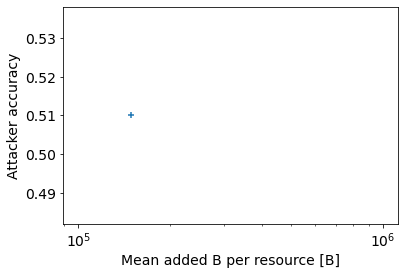

In [104]:
len_cuts = [row[0] for row in to_plot]
mean_costs = [row[1] for row in to_plot]
accs = [row[2] for row in to_plot]

plt.scatter(mean_costs, accs, marker="+")
plt.ylabel("Attacker accuracy")
plt.xlabel("Mean added B per resource [B]")
plt.xscale('log')

50 0.4770483725709137 0.4823999728589126 0.010313307332877716 0.03023834723729607


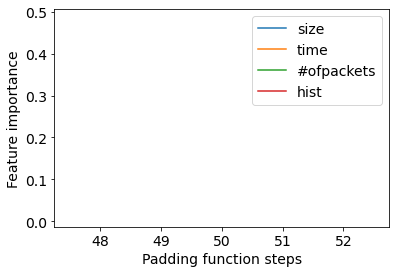

In [114]:
# understand how features evolve

def find_importance(features_and_importance, feature_name):
    for feature, importance, _ in features_and_importance:
        if feature == feature_name:
            return importance

    return 0

def sum_all_matching(features_and_importance, keyword):
    su = 0
    for feature, importance, _ in features_and_importance:
        if keyword in feature:
            su += importance

    return su

tuples = []


for cuts, med_cost, mean_cost in padding_functions:
    if not len(cuts) in clf_perf: # if the attack was not run, skip
        continue

    features = clf_perf[len(cuts)]['features']


    print(len(cuts), sum_all_matching(features, "byte"), sum_all_matching(features, "time"), sum_all_matching(features, "n_"), sum_all_matching(features, "hist"))

    tuples.append([len(cuts), sum_all_matching(features, "byte"), sum_all_matching(features, "time"), sum_all_matching(features, "n_"), sum_all_matching(features, "hist")])

xs = [t[0] for t in tuples]
ys1 = [t[1] for t in tuples]
ys2 = [t[2] for t in tuples]
ys3 = [t[3] for t in tuples]
ys4 = [t[4] for t in tuples]

plt.subplot(1, 1, 1)
plt.plot(xs, ys1, label="size")
plt.plot(xs, ys2, label="time")
plt.plot(xs, ys3, label="#ofpackets")
plt.plot(xs, ys4, label="hist")
plt.xlabel("Padding function steps")
plt.ylabel("Feature importance")
plt.legend(loc='upper right')
plt.show()
    

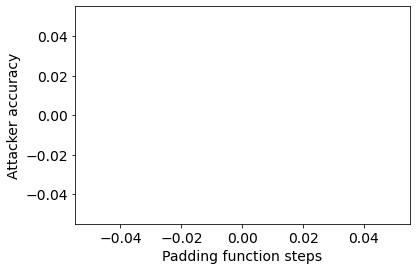

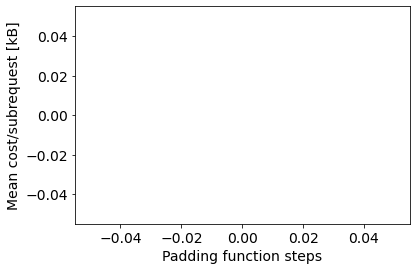

In [116]:
to_plot = []

for cuts, med_cost, mean_cost in padding_functions:

    if not len(cuts) in clf_perf: # if the attack was not run, skip
        continue
    if len(cuts) == last_size: # skips repeat due to rounding in np.linrange
        continue

    last_size = len(cuts)
    acc = round(clf_perf[len(cuts)]['score']['accuracy'][0], 2)
    top_f = [feature_name for feature_name, *_ in clf_perf[len(cuts)]['features'][:3]]
    mean_cost_str = f"{round(mean_cost)} B"
    if mean_cost > 1024:
        mean_cost_str = f"{round(mean_cost/1024)} kB"
    txt += f"Padding function steps: {len(cuts)}, mean extra cost per subresource {mean_cost_str}, accuracy {acc}, top features: {top_f}\n"
    

    to_plot.append([len(cuts), mean_cost, acc])

len_cuts = [row[0] for row in to_plot]
mean_costs = [row[1]/1024 for row in to_plot]
accs = [row[2] for row in to_plot]

plt.scatter(len_cuts, accs, marker="+")
plt.ylabel("Attacker accuracy")
plt.xlabel("Padding function steps")
plt.show()
plt.scatter(len_cuts, mean_costs, marker=".")
plt.ylabel("Mean cost/subrequest [kB]")
plt.xlabel("Padding function steps")
plt.show()

In [145]:
import bisect

def pad_request(request, cuts):
    t, out, inc = request
    # pad response
    next_padded_size_index = bisect.bisect_left(cuts, inc)
    next_padded_size = cuts[next_padded_size_index]
    return [t, 600, next_padded_size], (600-out)+(next_padded_size-inc)

def pad_to_cuts(data, cuts):
    data2 = {}
    costs_per_website = []
    for url in data:
        costs = []
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                padded, cost = pad_request(request, cuts)
                data2[url][sample].append(padded)
                costs.append(cost)
        costs_per_website.append([np.median(costs), np.mean(costs)])
    return data2, costs_per_website

def inject_dummy_request_at_the_end(data, samples_to_inject, cuts, p=0.5): # modifies data in place. Only in 20% of the cases, recursive
    costs = []

    for url in data:
        costs_this_website = []
        for sample in data[url]:
            requests = data[url][sample]
            last_t = 0
            if len(requests) > 0:
                last_t = requests[-1][0]


            extra_bw = 0
            extra_time = 0
            extra_req = 0

            if random.random() < p:
                # pick a sample at random
                chosen_sample = random.choice(samples_to_inject)

                # pick a starting subresource at random in the first half
                random_start = random.randint(0, int(len(chosen_sample)/2))

                # pick the end
                random_end = random.randint(random_start, len(chosen_sample))

                # apply the same padding to the tail
                padded_samples = [pad_request(request, cuts)[0] for request in chosen_sample[random_start:random_end]]

                # shift by last_t
                padded_samples = [[t + last_t, out, inc] for t, out, inc in padded_samples]

                for extra_request in padded_samples:
                    data[url][sample].append(extra_request)
                    extra_bw += extra_request[1] + extra_request[2] # add up and down
                    extra_time = extra_request[0] # max (they are sorted)
                extra_req += len(padded_samples)

            costs_this_website.append([extra_bw, extra_time, extra_req])

        med_bw = np.median([cost[0] for cost in costs_this_website])
        mean_bw = np.mean([cost[0] for cost in costs_this_website])
        added_time = np.mean([cost[1] for cost in costs_this_website])
        added_req = np.mean([cost[2] for cost in costs_this_website])
        costs.append([med_bw, mean_bw, added_time, added_req])

    cost_summary = []

    med_bw = np.mean([cost[0] for cost in costs])
    mean_bw = np.mean([cost[1] for cost in costs])
    added_time = np.mean([cost[2] for cost in costs])
    added_req = np.mean([cost[3] for cost in costs])
    cost_summary = [med_bw, mean_bw, added_time, added_req]

    return data, cost_summary

HEAVY_WEBSITES_SUBRESOURCES = []
for url in data:
    for sample in data[url]:
        if len(data[url][sample]) > 40: # magic number
            HEAVY_WEBSITES_SUBRESOURCES.append(data[url][sample])

print(f"Identified {len(HEAVY_WEBSITES_SUBRESOURCES)} request-heavy websites")

clf_perfs_varying_p = None
if os.path.isfile('clf_perfs_varying_p'+TMP_FILE):
    clf_perfs_varying_p = np.load('clf_perfs_varying_p'+TMP_FILE, allow_pickle=True).item()


if True or clf_perfs_varying_p is None:
    clf_perfs_varying_p = {}

    cuts, med_cost, mean_cost = padding_functions[-2]
    print("Padding function", cuts, med_cost, mean_cost)

    # baseline, no defense
    features = get_features(data)
    clf_res = rf_with_rfe(features)
    clf_perfs_varying_p["baseline"] = [clf_res, [0,0,0,0]]

    for p in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        print(f"***************** Working on p={p}")
        data_padded, padding_costs = pad_to_cuts(data, cuts)
        data_with_dummies, dummies_cost = inject_dummy_request_at_the_end(data_padded, HEAVY_WEBSITES_SUBRESOURCES, cuts, p=p)

        # todo use padding_costs

        print("Dummies cost", dummies_cost)

        features = get_features(data_with_dummies)
        clf_res = rf_with_rfe(features)

        print(clf_res)

        clf_perfs_varying_p[str(p)] = [clf_res, dummies_cost]

    np.save('clf_perfs_varying_p'+TMP_FILE, clf_perfs_varying_p, allow_pickle=True)

for p in clf_perfs_varying_p:
    clf_perf_this_p = clf_perfs_varying_p[p]
    med_bw, mean_bw, added_time, added_req = clf_perf_this_p[1]
    acc = round(clf_perf_this_p[0]['score']['accuracy'][0], 2)
    cost_str = f"costs: {round(med_bw,2)} [B] (median), {round(added_time,2)} extra sec, {round(added_req,2)} extra requests"
    print(f"p={p} acc={acc}% {cost_str}")

Identified 2878 request-heavy websites
Padding function [780, 879, 961, 1151, 1523, 1830, 2000, 2128, 2272, 2428, 2554, 2747, 2978, 3195, 3492, 3798, 4169, 4606, 4984, 5484, 5984, 6415, 7022, 7751, 8584, 9347, 10117, 11119, 12353, 13516, 15182, 16674, 17390, 18764, 20974, 22810, 24552, 27226, 30852, 33797, 37348, 42387, 47923, 57730, 70983, 83086, 111047, 151837, 269067, 8006333] 289.0 148534.2053558159
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
*

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [0.0, 0.0, 0.0, 0.0]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.8354838709677418, 0.006539223685575362), 'precision': (0.8354838709677418, 0.006539223685575362), 'recall': (0.8354838709677418, 0.006539223685575362), 'f1score': (0.8354838709677418, 0.006539223685575354)}, 'features': [('bytes_incoming', 0.1426977655348555, 0.009105452773857908), ('bytes_total', 0.1425665331891679, 0.008457298630404142), ('time

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [0.0, 542898.6016808384, 0.5420232726627935, 2.5226290498138293]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.7566935483870967, 0.014434357497955092), 'precision': (0.7566935483870967, 0.014434357497955092), 'recall': (0.7566935483870967, 0.014434357497955092), 'f1score': (0.7566935483870967, 0.014434357497955082)}, 'features': [('bytes_incoming', 0.13602698378620298, 0.005199308715688144), ('bytes_total', 0.13

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [0.0, 1125430.9524986711, 1.1003800685699587, 5.177046783289792]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.677741935483871, 0.006625185289851889), 'precision': (0.677741935483871, 0.006625185289851889), 'recall': (0.677741935483871, 0.006625185289851889), 'f1score': (0.677741935483871, 0.006625185289851889)}, 'features': [('bytes_incoming', 0.14533602057802741, 0.006089962350525576), ('bytes_total', 0.143772

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [5215.709627329193, 1689535.6499698125, 1.5736978118279406, 7.564413425947848]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.6096774193548387, 0.010090317939937879), 'precision': (0.6096774193548387, 0.010090317939937879), 'recall': (0.6096774193548387, 0.010090317939937879), 'f1score': (0.6096774193548387, 0.010090317939937879)}, 'features': [('times_sum', 0.06342984069825605, 0.06432590767198222), ('bytes_inco

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [5383.8540372670805, 2043013.2285615527, 2.0801722515642043, 9.75244314242831]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.5485887096774194, 0.016390273457018257), 'precision': (0.5485887096774194, 0.016390273457018257), 'recall': (0.5485887096774194, 0.016390273457018257), 'f1score': (0.5485887096774194, 0.016390273457018257)}, 'features': [('bytes_incoming', 0.129996675557196, 0.007227086296604958), ('bytes_

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [36662.358695652176, 2631675.917683229, 2.6434261019546743, 12.439397026815847]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.4915725806451613, 0.016389479840058355), 'precision': (0.4915725806451613, 0.016389479840058355), 'recall': (0.4915725806451613, 0.016389479840058355), 'f1score': (0.4915725806451613, 0.016389479840058355)}, 'features': [('bytes_incoming', 0.13046924245634486, 0.005524419666465551), ('byt

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [126845.49844720497, 3291160.435658024, 3.1382688693072507, 14.985914963833496]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.4220564516129032, 0.01172000621952224), 'precision': (0.4220564516129032, 0.01172000621952224), 'recall': (0.4220564516129032, 0.01172000621952224), 'f1score': (0.4220564516129032, 0.01172000621952224)}, 'features': [('bytes_total', 0.12540088031223617, 0.0038730587364004428), ('bytes_inc

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [204537.09472049688, 3534733.094626295, 3.7077992367980435, 17.56214392621193]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.36786290322580645, 0.027759424579152602), 'precision': (0.36786290322580645, 0.027759424579152602), 'recall': (0.36786290322580645, 0.027759424579152602), 'f1score': (0.36786290322580645, 0.027759424579152602)}, 'features': [('bytes_incoming', 0.1200017650293039, 0.0028082323839579305), ('

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [287089.39751552796, 4075204.221779262, 4.225829262680466, 20.141093169028395]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.3189516129032258, 0.02312070192360445), 'precision': (0.3189516129032258, 0.02312070192360445), 'recall': (0.3189516129032258, 0.02312070192360445), 'f1score': (0.3189516129032258, 0.02312070192360446)}, 'features': [('bytes_incoming', 0.1144099152934692, 0.0020042295902901104), ('bytes_to

/usr/lib64/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib64/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dummies cost [363950.89906832296, 4547259.735490249, 4.735220146282612, 22.562894643950468]
Skipping admin.danangsunbay.com only 7 samples
Skipping abookandahug.com only 17 samples
Skipping gc-geoip-us.deepernetworks.org only 17 samples
Skipping themesjar.com only 18 samples
Skipping kilishaber.tk only 2 samples
Skipping onlinecasino002.com only 3 samples
[feature_extract] Number of classes 316
[feature_extract] Number of features 123
[feature_extract] Number of samples 12400
[feature_extract] Number of labels 12400
Number of classes 316
Number of features 123
Number of samples 12400
Number of labels 12400
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
{'score': {'accuracy': (0.27963709677419357, 0.02062156066615746), 'precision': (0.27963709677419357, 0.02062156066615746), 'recall': (0.27963709677419357, 0.02062156066615746), 'f1score': (0.27963709677419357, 0.02062156066615746)}, 'features': [('bytes_incoming', 0.11028412184322327, 0.0025986599901112106), ('int

In [146]:

for p in clf_perfs_varying_p:
    clf_perf_this_p = clf_perfs_varying_p[p]
    med_bw, mean_bw, added_time, added_req = clf_perf_this_p[1]
    acc = round(clf_perf_this_p[0]['score']['accuracy'][0], 2)
    cost_str = f"costs: {round(med_bw,2)} med [B], {round(added_time,2)} extra sec, {round(added_req,2)} extra requests"
    print(f"p={p} acc={acc}% {cost_str}")

p=baseline acc=0.96% costs: 0 med [B], 0 extra sec, 0 extra requests
p=0 acc=0.84% costs: 0.0 med [B], 0.0 extra sec, 0.0 extra requests
p=0.1 acc=0.76% costs: 0.0 med [B], 0.54 extra sec, 2.52 extra requests
p=0.2 acc=0.68% costs: 0.0 med [B], 1.1 extra sec, 5.18 extra requests
p=0.3 acc=0.61% costs: 5215.71 med [B], 1.57 extra sec, 7.56 extra requests
p=0.4 acc=0.55% costs: 5383.85 med [B], 2.08 extra sec, 9.75 extra requests
p=0.5 acc=0.49% costs: 36662.36 med [B], 2.64 extra sec, 12.44 extra requests
p=0.6 acc=0.42% costs: 126845.5 med [B], 3.14 extra sec, 14.99 extra requests
p=0.7 acc=0.37% costs: 204537.09 med [B], 3.71 extra sec, 17.56 extra requests
p=0.8 acc=0.32% costs: 287089.4 med [B], 4.23 extra sec, 20.14 extra requests
p=0.9 acc=0.28% costs: 363950.9 med [B], 4.74 extra sec, 22.56 extra requests


In [150]:
def deepcopy(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                data2[url][sample].append(request)
    return data2

# same thing, no padding
def inject_dummy_request_at_the_end2(data, samples_to_inject, p=0.5): # modifies data in place. Only in 20% of the cases, recursive
    costs = []

    for url in data:
        costs_this_website = []
        for sample in data[url]:
            requests = data[url][sample]
            last_t = 0
            if len(requests) > 0:
                last_t = requests[-1][0]


            extra_bw = 0
            extra_time = 0
            extra_req = 0

            if random.random() < p:
                # pick a sample at random
                chosen_sample = random.choice(samples_to_inject)

                # pick a starting subresource at random in the first half
                random_start = random.randint(0, int(len(chosen_sample)/2))

                # pick the end
                random_end = random.randint(random_start, len(chosen_sample))

                # shift by last_t
                padded_samples = [[t + last_t, out, inc] for t, out, inc in chosen_sample[random_start:random_end]]

                for extra_request in padded_samples:
                    data[url][sample].append(extra_request)
                    extra_bw += extra_request[1] + extra_request[2] # add up and down
                    extra_time = extra_request[0] # max (they are sorted)
                extra_req += len(padded_samples)

            costs_this_website.append([extra_bw, extra_time, extra_req])

        med_bw = np.median([cost[0] for cost in costs_this_website])
        mean_bw = np.mean([cost[0] for cost in costs_this_website])
        added_time = np.mean([cost[1] for cost in costs_this_website])
        added_req = np.mean([cost[2] for cost in costs_this_website])
        costs.append([med_bw, mean_bw, added_time, added_req])

    cost_summary = []

    med_bw = np.mean([cost[0] for cost in costs])
    mean_bw = np.mean([cost[1] for cost in costs])
    added_time = np.mean([cost[2] for cost in costs])
    added_req = np.mean([cost[3] for cost in costs])
    cost_summary = [med_bw, mean_bw, added_time, added_req]

    return data, cost_summary

HEAVY_WEBSITES_SUBRESOURCES = []
for url in data:
    for sample in data[url]:
        if len(data[url][sample]) > 40: # magic number
            HEAVY_WEBSITES_SUBRESOURCES.append(data[url][sample])

print(f"Identified {len(HEAVY_WEBSITES_SUBRESOURCES)} request-heavy websites")

clf_perfs_varying_p_no_pad = None
if os.path.isfile('clf_perfs_varying_p_no_pad'+TMP_FILE):
    clf_perfs_varying_p_no_pad = np.load('clf_perfs_varying_p_no_pad'+TMP_FILE, allow_pickle=True).item()

if clf_perfs_varying_p_no_pad is None:
    clf_perfs_varying_p_no_pad = {}

    cuts, med_cost, mean_cost = padding_functions[-2]
    print("Padding function", cuts, med_cost, mean_cost)

    # baseline, no defense
    features = get_features(data)
    clf_res = rf_with_rfe(features)
    clf_perfs_varying_p_no_pad["baseline"] = [clf_res, [0,0,0,0]]

    for p in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        print(f"***************** Working on p={p}")
        data2 = deepcopy(data)
        data_with_dummies, dummies_cost = inject_dummy_request_at_the_end2(data2, HEAVY_WEBSITES_SUBRESOURCES, p=p)

        print("Dummies cost", dummies_cost)

        features = get_features(data_with_dummies)
        clf_res = rf_with_rfe(features)

        print(clf_res)

        clf_perfs_varying_p_no_pad[str(p)] = [clf_res, dummies_cost]

    np.save('clf_perfs_varying_p_no_pad'+TMP_FILE, clf_perfs_varying_p_no_pad, allow_pickle=True)

for p in clf_perfs_varying_p_no_pad:
    clf_perf_this_p = clf_perfs_varying_p_no_pad[p]
    med_bw, mean_bw, added_time, added_req = clf_perf_this_p[1]
    acc = round(clf_perf_this_p[0]['score']['accuracy'][0], 2)
    cost_str = f"costs: {round(med_bw,2)} [B] (median), {round(added_time,2)} extra sec, {round(added_req,2)} extra requests"
    print(f"p={p} acc={acc}% {cost_str}")

Identified 2878 request-heavy websites
p=baseline acc=0.96% costs: 0 [B] (median), 0 extra sec, 0 extra requests
p=0 acc=0.96% costs: 0.0 [B] (median), 0.0 extra sec, 0.0 extra requests
p=0.1 acc=0.88% costs: 0.0 [B] (median), 0.5 extra sec, 2.41 extra requests
p=0.5 acc=0.55% costs: 38946.95 [B] (median), 2.68 extra sec, 12.77 extra requests
p=0.9 acc=0.23% costs: 349983.64 [B] (median), 4.77 extra sec, 22.94 extra requests


In [176]:
# how many subresources do we need to inject ?

def deepcopy(data):
    data2 = {}
    for url in data:
        data2[url] = {}
        for sample in data[url]:
            data2[url][sample] = []
            for request in data[url][sample]:
                data2[url][sample].append(request)
    return data2

# same thing, no padding
def inject_dummy_request_at_the_end2(data, samples_to_inject, p=0.5, howmany=-1): # modifies data in place. Only in 20% of the cases, recursive
    costs = []

    for url in data:
        costs_this_website = []
        for sample in data[url]:
            requests = data[url][sample]
            last_t = 0
            if len(requests) > 0:
                last_t = requests[-1][0]


            extra_bw = 0
            extra_time = 0
            extra_req = 0

            if random.random() < p:
                # pick a sample at random
                chosen_sample = random.choice(samples_to_inject)

                # pick a starting subresource at random in the first half
                random_start = random.randint(0, int(len(chosen_sample)/2))

                end = len(chosen_sample)
                if howmany > -1 :
                    end = random_start + 2*howmany # twice, so E[length] = howmany

                if end > len(chosen_sample):
                    end = len(chosen_sample)

                # pick the end
                random_end = random.randint(random_start, end)

                # shift by last_t
                padded_samples = [[t + last_t, out, inc] for t, out, inc in chosen_sample[random_start:random_end]]

                for extra_request in padded_samples:
                    data[url][sample].append(extra_request)
                    extra_bw += extra_request[1] + extra_request[2] # add up and down
                    extra_time = extra_request[0] # max (they are sorted)
                extra_req += len(padded_samples)

            costs_this_website.append([extra_bw, extra_time, extra_req])

        med_bw = np.median([cost[0] for cost in costs_this_website])
        mean_bw = np.mean([cost[0] for cost in costs_this_website])
        added_time = np.mean([cost[1] for cost in costs_this_website])
        added_req = np.mean([cost[2] for cost in costs_this_website])
        costs.append([med_bw, mean_bw, added_time, added_req])

    cost_summary = []

    med_bw = np.mean([cost[0] for cost in costs])
    mean_bw = np.mean([cost[1] for cost in costs])
    added_time = np.mean([cost[2] for cost in costs])
    added_req = np.mean([cost[3] for cost in costs])
    cost_summary = [med_bw, mean_bw, added_time, added_req]

    return data, cost_summary

HEAVY_WEBSITES_SUBRESOURCES = []
for url in data:
    for sample in data[url]:
        if len(data[url][sample]) > 40: # magic number
            HEAVY_WEBSITES_SUBRESOURCES.append(data[url][sample])

print(f"Identified {len(HEAVY_WEBSITES_SUBRESOURCES)} request-heavy websites")

clf_perfs_varying_p_no_pad_howmany = None
if os.path.isfile('clf_perfs_varying_p_no_pad_howmany'+TMP_FILE):
    clf_perfs_varying_p_no_pad_howmany = np.load('clf_perfs_varying_p_no_pad_howmany'+TMP_FILE, allow_pickle=True).item()

if clf_perfs_varying_p_no_pad_howmany is None:
    clf_perfs_varying_p_no_pad_howmany = {}

    cuts, med_cost, mean_cost = padding_functions[-2]
    print("Padding function", cuts, med_cost, mean_cost)

    # baseline, no defense
    features = get_features(data)
    clf_res = rf_with_rfe(features)
    clf_perfs_varying_p_no_pad_howmany["baseline"] = dict(none=[clf_res, [0,0,0,0]])

    for p in [0, 0.25, 0.5, 1]:
        for howmany in [1, 5, 10, 20, 30, 40, 50]:
            print(f"***************** Working on p={p}, howmany={howmany}")
            data2 = deepcopy(data)
            data_with_dummies, dummies_cost = inject_dummy_request_at_the_end2(data2, HEAVY_WEBSITES_SUBRESOURCES, p=p, howmany=howmany)

            print("Dummies cost", dummies_cost)

            features = get_features(data_with_dummies)
            clf_res = rf_with_rfe(features)

            print(clf_res)

            if not str(p) in clf_perfs_varying_p_no_pad_howmany:
                clf_perfs_varying_p_no_pad_howmany[str(p)] = dict()

            clf_perfs_varying_p_no_pad_howmany[str(p)][str(howmany)] = [clf_res, dummies_cost]

    np.save('clf_perfs_varying_p_no_pad_howmany'+TMP_FILE, clf_perfs_varying_p_no_pad_howmany, allow_pickle=True)

for p in clf_perfs_varying_p_no_pad_howmany:
    for howmany in clf_perfs_varying_p_no_pad_howmany[p]:
        clf_perf_this_p = clf_perfs_varying_p_no_pad_howmany[p][howmany]
        
        med_bw, mean_bw, added_time, added_req = clf_perf_this_p[1]

        acc = round(clf_perf_this_p[0]['score']['accuracy'][0], 2)
        cost_str = f"costs: {round(med_bw,2)} [B] (median), {round(added_time,2)} extra sec, {round(added_req,2)} extra requests"
        print(f"p={p} acc={acc}% {cost_str}")

Identified 2878 request-heavy websites
p=baseline acc=0.96% costs: 0 [B] (median), 0 extra sec, 0 extra requests
p=0 acc=0.96% costs: 0.0 [B] (median), 0.0 extra sec, 0.0 extra requests
p=0 acc=0.96% costs: 0.0 [B] (median), 0.0 extra sec, 0.0 extra requests
p=0 acc=0.96% costs: 0.0 [B] (median), 0.0 extra sec, 0.0 extra requests
p=0 acc=0.96% costs: 0.0 [B] (median), 0.0 extra sec, 0.0 extra requests
p=0 acc=0.96% costs: 0.0 [B] (median), 0.0 extra sec, 0.0 extra requests
p=0 acc=0.96% costs: 0.0 [B] (median), 0.0 extra sec, 0.0 extra requests
p=0 acc=0.96% costs: 0.0 [B] (median), 0.0 extra sec, 0.0 extra requests
p=0.25 acc=0.91% costs: 0.0 [B] (median), 0.66 extra sec, 0.25 extra requests
p=0.25 acc=0.84% costs: 799.71 [B] (median), 0.92 extra sec, 1.26 extra requests
p=0.25 acc=0.8% costs: 96.6 [B] (median), 0.99 extra sec, 2.39 extra requests
p=0.25 acc=0.77% costs: 5846.34 [B] (median), 1.16 extra sec, 4.56 extra requests
p=0.25 acc=0.75% costs: 3627.48 [B] (median), 1.27 extra 

baseline
0
0.25
0.5
1


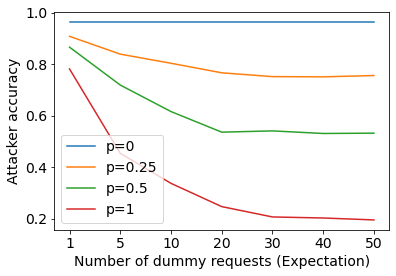

In [189]:

for p in clf_perfs_varying_p_no_pad_howmany:
    print(p)
    if p == "baseline":
        continue

    xs = []
    ys = []
    for howmany in clf_perfs_varying_p_no_pad_howmany[p]:
        clf_perf_this_p = clf_perfs_varying_p_no_pad_howmany[p][howmany]
        
        med_bw, mean_bw, added_time, added_req = clf_perf_this_p[1]
        acc = clf_perf_this_p[0]['score']['accuracy']
        ys.append(acc[0])
        xs.append(howmany)
    
    plt.xlabel("Number of dummy requests (Expectation)")
    plt.ylabel("Attacker accuracy")
    plt.plot(np.arange(len(ys)), ys, label=f"p={p}")
    plt.xticks(np.arange(len(ys)), xs)
    plt.legend()
plt.show()

baseline
0
0.25
0.5
1


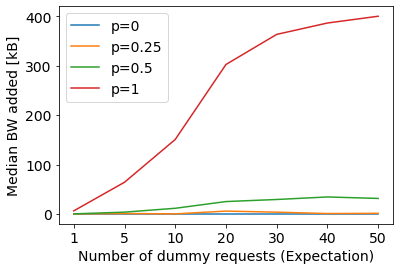

In [192]:

for p in clf_perfs_varying_p_no_pad_howmany:
    print(p)
    if p == "baseline":
        continue

    xs = []
    ys = []
    for howmany in clf_perfs_varying_p_no_pad_howmany[p]:
        clf_perf_this_p = clf_perfs_varying_p_no_pad_howmany[p][howmany]
        
        med_bw, mean_bw, added_time, added_req = clf_perf_this_p[1]
        acc = clf_perf_this_p[0]['score']['accuracy']
        ys.append(med_bw/1024)
        xs.append(howmany)
    
    plt.plot(np.arange(len(ys)), ys, label=f"p={p}")
    plt.xticks(np.arange(len(ys)), xs)

plt.xlabel("Number of dummy requests (Expectation)")
plt.ylabel("Median BW added [kB]")
plt.legend()
plt.show()

baseline
0
0.25
0.5
1


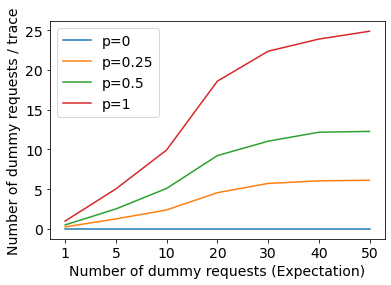

In [201]:
for p in clf_perfs_varying_p_no_pad_howmany:
    print(p)
    if p == "baseline":
        continue

    xs = []
    ys = []
    for howmany in clf_perfs_varying_p_no_pad_howmany[p]:
        clf_perf_this_p = clf_perfs_varying_p_no_pad_howmany[p][howmany]
        
        med_bw, mean_bw, added_time, added_req = clf_perf_this_p[1]
        acc = clf_perf_this_p[0]['score']['accuracy']
        ys.append(added_req)
        xs.append(howmany)
    
    plt.plot(np.arange(len(ys)), ys, label=f"p={p}")
    plt.xticks(np.arange(len(ys)), xs)

plt.xlabel("Number of dummy requests (Expectation)")
plt.ylabel("Number of dummy requests / trace")
plt.legend()
plt.show()

baseline
0
0.25
0.5
1


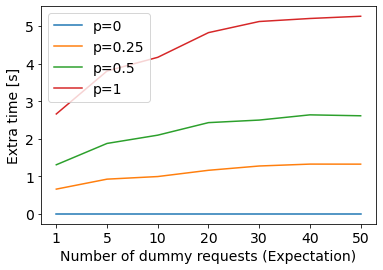

In [202]:
for p in clf_perfs_varying_p_no_pad_howmany:
    print(p)
    if p == "baseline":
        continue

    xs = []
    ys = []
    for howmany in clf_perfs_varying_p_no_pad_howmany[p]:
        clf_perf_this_p = clf_perfs_varying_p_no_pad_howmany[p][howmany]
        
        med_bw, mean_bw, added_time, added_req = clf_perf_this_p[1]
        acc = clf_perf_this_p[0]['score']['accuracy']
        ys.append(added_time)
        xs.append(howmany)
    
    plt.plot(np.arange(len(ys)), ys, label=f"p={p}")
    plt.xticks(np.arange(len(ys)), xs)

plt.xlabel("Number of dummy requests (Expectation)")
plt.ylabel("Extra time [s]")
plt.legend()
plt.show()